# Face Recognition Clustering
In this project, I will practice working with images, from the process of preparing the images to extracting the features from the images using a trained embedding model. I will use these features in order to divide the images into clusters, that is to associate different images of the same person to the same cluster. I will work with images of famous people. The images can contain more than one person or many backgrounds beyond the face so I will have to crop them. The open_cv and face_recognition libraries are used in the work.

## Installs and downloads:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
! pip install face_recognition
import face_recognition  # The package requires to change runtime to Hardware accelerator - GPU T4
!pip install opencv-python-headless
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import shutil
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=1ffadfbecaa3259e620210410d9723eaad8ad32685fa055854f234f23706ad81
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


## Section A - Preprocess:
In this section, I will load the images using the open-cv (cv2) library, and find the faces in each image.

As it can be seen, the data file is in my Google Drive in a folder called 'images' which contains about 200 pictures of famous people.

In [3]:
folder_path = '/content/drive/MyDrive/images'  # Set the path of the images folder
all_images_list = []
image_files = os.listdir(folder_path)  # Get the list of image file names in the folder

for file_name in image_files:  # Iterate over the images
    if file_name.endswith('.png') or file_name.endswith('.jpg'):
        image_path = os.path.join(folder_path, file_name)
        image = cv2.imread(image_path)
        all_images_list.append(image)

print(f"There are overall {len(all_images_list)} images in the folder")

There are overall 200 images in the folder


Now, I will save the coordinates of each face in each image in order to crop only the face from the image. I will cut each face by marking a blue rectangle, and I will create a 'faces' folder in which we will save all the faces found.

As it can be seen, 360 faces were found after the face detection and cropping phase.

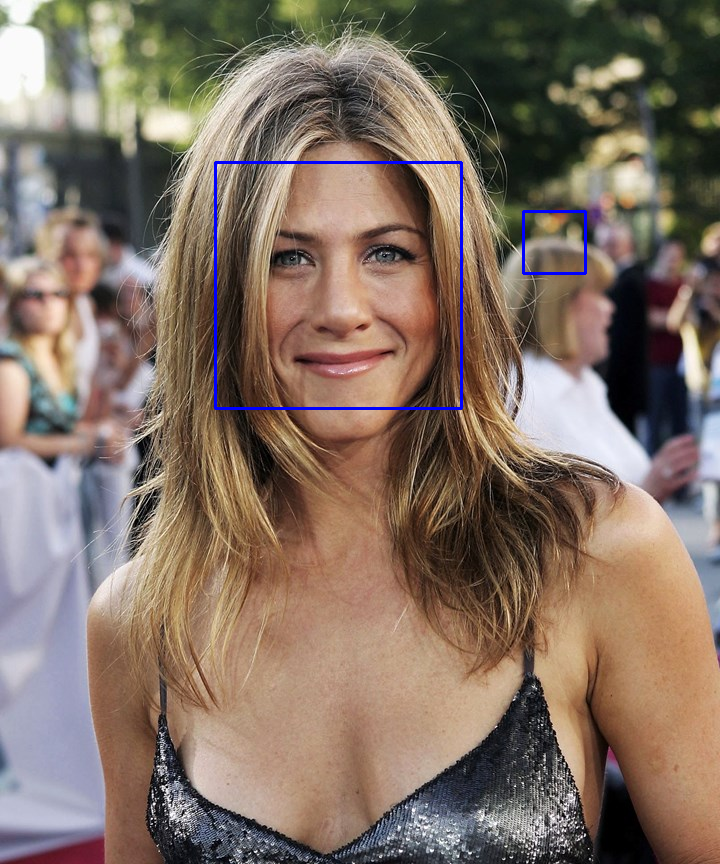

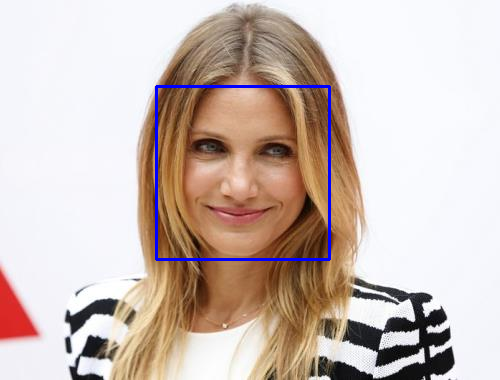

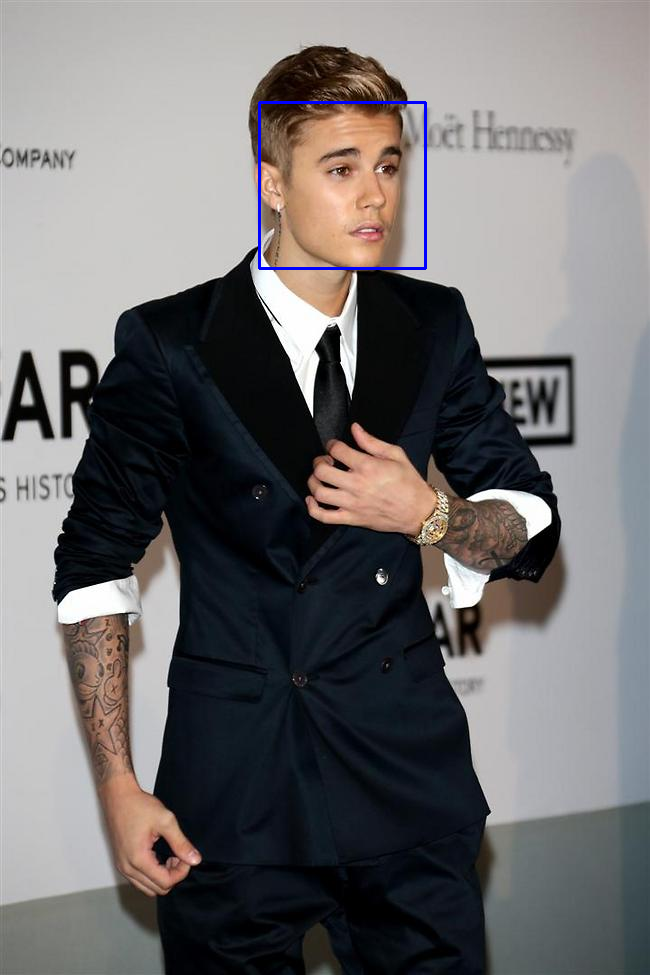

360 faces were found after the face detection and cropping phase


In [4]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  # Load the pre-trained face cascade classifier
faces_dir_path = '/content/drive/MyDrive/faces'
if not os.path.exists(faces_dir_path):
  os.makedirs(faces_dir_path)  # Create 'faces' directory if not exits

num_of_faces = 0
blue_rectangles = 0
for img_idx, image in enumerate(all_images_list):  # Iterate over the images in all_images_list
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale for face detection
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))  # Detect faces in the image
    for face_idx, (x, y, w, h) in enumerate(faces):  # Iterate over the detected faces
        face_name = f'image{img_idx + 1}_face{face_idx + 1}.jpg'  # Create a unique name for each image of a face
        face_path = os.path.join(faces_dir_path, face_name)
        cv2.imwrite(face_path, image[y:y+h, x:x+w])
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw a blue rectangle around each face
        num_of_faces += 1
        blue_rectangles += 1
        if 1 < blue_rectangles < 5:  # Display examples of some images on the screen
          cv2_imshow(image)

print(f"{num_of_faces} faces were found after the face detection and cropping phase")

### Extracting features from each face, and creating a 128 size vector
In this part, I will extract features from each face using the face_recognition library, and create a vector of size 128 representing the features of each image.
Apparently, some of the images initially identified as faces are actually not faces and I will be able to detect this using face_recognition which classifies such images as None. I will remove from the 'faces' folder photos classified as None.

As it can be seen, 262 faces were found after the face detection filtering.

In [5]:
faces_dict = {}
for img_face in os.listdir(faces_dir_path):  # Iterates over all the face images in the directory
  img_face_path = os.path.join(faces_dir_path, img_face)  # The face image path
  curr_img_features = face_recognition.face_encodings(face_recognition.load_image_file(img_face_path))  # Loads an image file into a 128-dimensional numpy array

  if curr_img_features is None or len(curr_img_features) == 0:  # Remove the image if it is not a face or couldn't be recognized as a face
    os.remove(img_face_path)
  else:
    faces_dict[img_face] = curr_img_features[0]

faces_df = pd.DataFrame.from_dict(faces_dict, orient='index').reset_index().rename(columns={'index': 'Face_Image_Name'})  # The dictionary keys are used as the index of the DataFrame
print(f"{len(faces_dict)} faces were found after the face detection filtering\n")

262 faces were found after the face detection filtering



In [6]:
# Save the DataFrame to the drive as a csv file
faces_df.to_csv("/content/drive/MyDrive/face_features_table.csv", index=False)

In [ ]:
# Read the csv file to avoid running the previous code
# faces_df = pd.read_csv("/content/drive/MyDrive/face_features_table.csv")

## Section B - Find best K:
In this section, I will select a range of K values that seems reasonable to us given the data in order to create a K-Means model that I will apply to the images. After that, I will save the Inertia values and the Silhouette score. I will create two graphs of the K values for the values of each measure. Finally, I will choose the best K.

After getting frustrated with the 262 images of the faces, I noticed that each celebrity has about 4-6 photos in a rough estimate. Therefore, K was chosen which is in the range between 40 and 60.

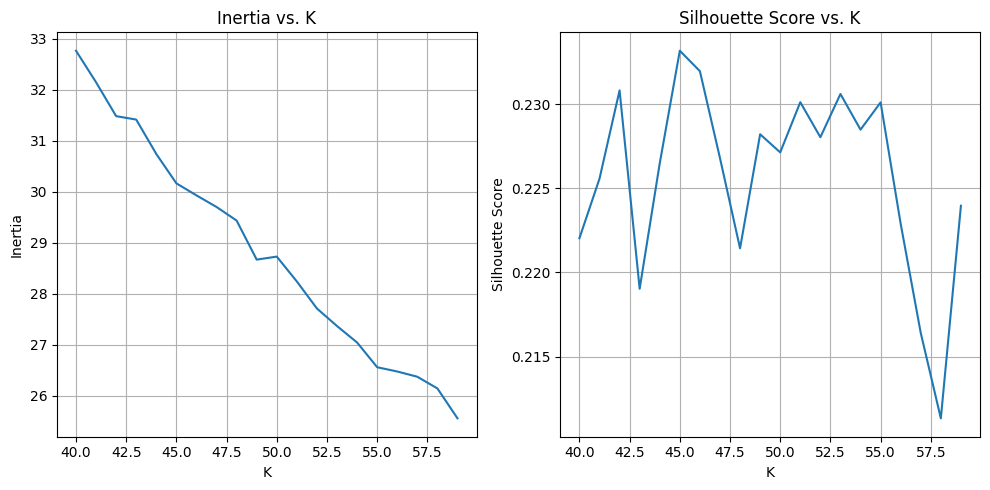

In [7]:
face_features = np.array(faces_df.drop('Face_Image_Name', axis=1))  # Extract the face features as an array
reasonable_k_values = range(40, 60)  # Define the reasonable range of K values given the the data
inertia_values_1 = []
silhouette_scores_1 = []

# Train models and calculate scores for the range of K values
for k in reasonable_k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(face_features)
    inertia_values_1.append(kmeans.inertia_)
    silhouette_scores_1.append(silhouette_score(face_features, kmeans.labels_))

# Plot the graphs for the range of K values
# Inertia vs. K plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(reasonable_k_values, inertia_values_1)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia vs. K')
plt.grid(True)

# Silhouette Score vs. K plot
plt.subplot(1, 2, 2)
plt.plot(reasonable_k_values, silhouette_scores_1)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. K')
plt.tight_layout()
plt.grid(True)
plt.show()

Now we will search for the optimal K on a wide range of K values, in order to present better visualization to find the elbow on the graph.

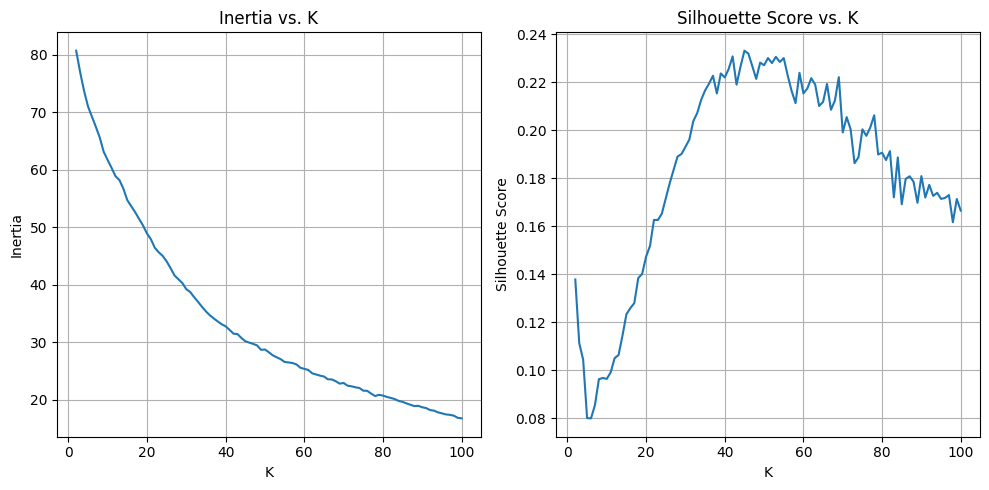

In [8]:
wide_k_values = range(2, 101)  # Define the range of K values for the first model
inertia_values_2 = []
silhouette_scores_2 = []

# Train models and calculate scores for the first range of K values
for k in wide_k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(face_features)
    inertia_values_2.append(kmeans.inertia_)
    silhouette_scores_2.append(silhouette_score(face_features, kmeans.labels_))

# Plot the graphs for the first range of K values
# Inertia vs. K plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(wide_k_values, inertia_values_2)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia vs. K')
plt.grid(True)

# Silhouette Score vs. K plot
plt.subplot(1, 2, 2)
plt.plot(wide_k_values, silhouette_scores_2)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. K')
plt.tight_layout()
plt.grid(True)
plt.show()

I will choose the optimal K with the help of the graphs I created. It can be seen that the K that yields the maximum Silhouette Score is in the range of 44 to 58. According to the Inertia graph, I would like to find the K that yields the elbow point, and it can be seen that it is difficult to decide unequivocally, but it is in the range between 50 and 60. Therefore, I choose **K=58** as the optimal K.

## Section C - KMeans with the selected K:
In this section, I will create a K-Means model with the selected K (58) and divide the data into clusters so that each cluster will be composed of images of the same famous person.
I will create a folder for each cluster and save all the images of a certain cluster in the appropriate folder. I.e., for K=58, I will create 58 folders and in each folder all the images of the faces associated with the cluster.

In [9]:
selected_k = 58  # The optimal K we selected

# Train a KMeans model with the selected K value
kmeans = KMeans(n_clusters=selected_k, n_init=10, random_state=42)
kmeans.fit(face_features)

# Create KMeans_clusters directory if not exists
kmeans_clusters_dir_path = '/content/drive/MyDrive/KMeans_clusters'
if not os.path.exists(kmeans_clusters_dir_path):
    os.makedirs(kmeans_clusters_dir_path)

# Assign each image to its corresponding cluster
for image_path, cluster_label in zip(faces_df['Face_Image_Name'], kmeans.labels_):  # Iterates over each face image, and its predicted cluster
    cluster_folder_path = os.path.join(kmeans_clusters_dir_path, f'cluster_{cluster_label}')
    if not os.path.exists(cluster_folder_path):  # Create cluster directory for each cluster if not exists yet (new cluster is created)
        os.makedirs(cluster_folder_path)
    image_face_path = os.path.join(faces_dir_path, image_path)  # Create image face path for each image in the faces directory
    shutil.copy(image_face_path, cluster_folder_path)  # Copy the image file (source) to the appropriate cluster folder (destination)

faces_df['pred_cluster'] = kmeans.labels_
for k in range(selected_k):
  cluster_folder_path = os.path.join(kmeans_clusters_dir_path, f'cluster_{k}')
  cluster_images = faces_df[faces_df['pred_cluster'] == k]  # Return only the records (images of faces) of the specific cluster
  cluster_file_path = os.path.join(cluster_folder_path, f'cluster_{k}.csv')
  cluster_images.to_csv(cluster_file_path, index=False)  # Create a csv file in each directory of the images of each cluster

Now, I will reduce dimensions using the TSNE method to two dimensions. I will present the clusters on a two-dimensional plane such that each data point colored according to the cluster to which it belongs. The diagram will include the centers of the clusters (medoids) so that there is an X mark on each data point that is the center of a cluster.

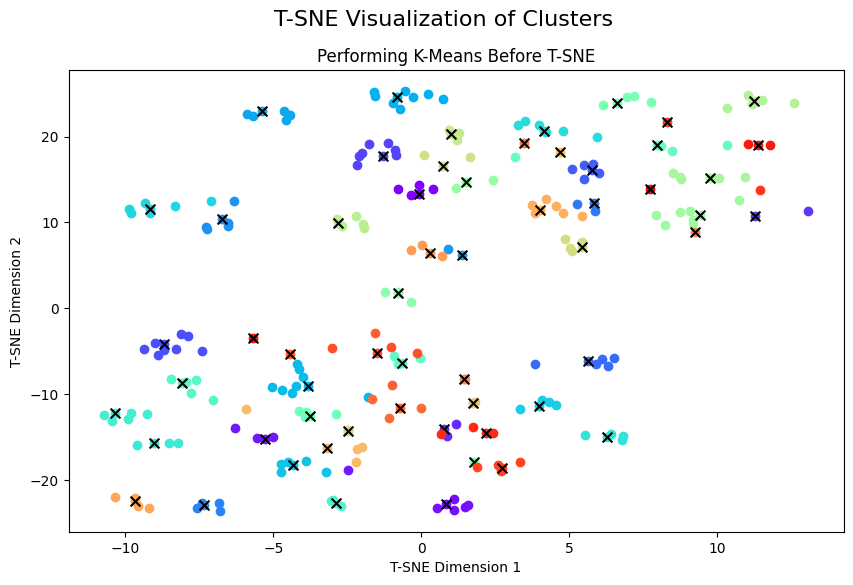

In [12]:
tsne = TSNE(n_components=2, random_state=42)  # Reduce dimensions to 2 using t-SNE
tsne_features = tsne.fit_transform(face_features)  # A transformed feature array with reduced dimensions
tsne_df = pd.DataFrame(tsne_features)
all_clusters = np.unique(faces_df['pred_cluster'])
cmap = plt.cm.rainbow(np.linspace(0, 1, len(all_clusters)))

plt.figure(figsize=(10, 6))
for i, j in enumerate(all_clusters):
    curr_cluster = tsne_df[faces_df['pred_cluster'] == j]
    medoid_num = cdist(curr_cluster, [curr_cluster.mean()]).argmin()  # Create the clusters and the medoids
    curr_medoid = curr_cluster.iloc[medoid_num]
    plt.scatter(curr_cluster[0], curr_cluster[1], color=cmap[i])
    plt.scatter(curr_medoid[0], curr_medoid[1], marker='x', color='black', s=50)  # Plot X marks for cluster centers (medoids)

plt.suptitle('T-SNE Visualization of Clusters', fontsize=16)
plt.title('Performing K-Means Before T-SNE', fontsize=12)
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.show()

## Section D - KMeans with the selected K after TSNE:
In this section, I will perform the reverse order of operations from the previous part. First, I will reduce the data to two dimensions using TSNE, and only then I will create a K-Means model with the selected K on the data.
I will present the clusters on a two-dimensional plot similar to the plots from the previous section.


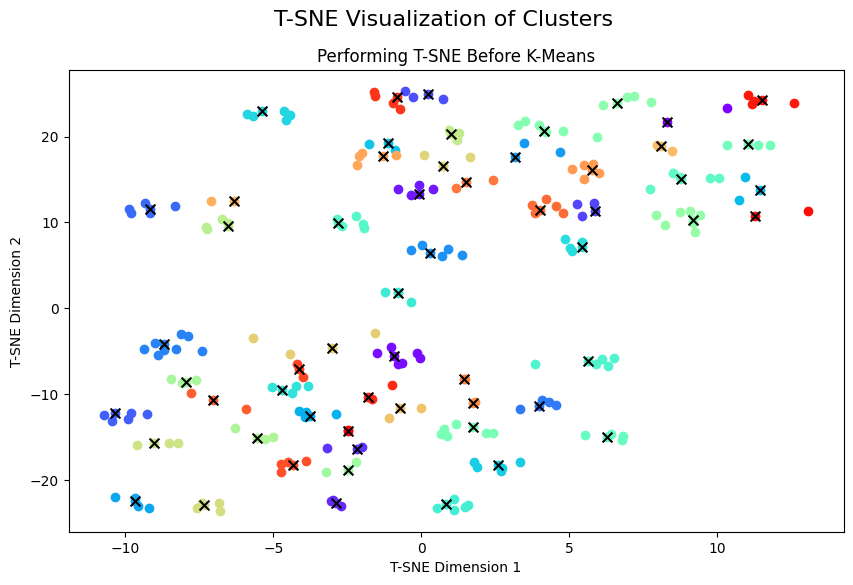

In [14]:
tsne = TSNE(n_components=2, random_state=42)  # Reduce dimensions to 2 using t-SNE
tsne_features = tsne.fit_transform(face_features)  # A transformed feature array with reduced dimensions
tsne_df = pd.DataFrame(tsne_features)

# Now we create a K-means model that train on the transformed feature array with reduced dimensions
kmeans_2d = KMeans(n_clusters=selected_k, n_init=10, random_state=42)
kmeans_2d.fit(tsne_df)
all_clusters = np.unique(kmeans_2d.labels_)
tsne_df['pred_cluster'] = kmeans_2d.labels_
cmap = plt.cm.rainbow(np.linspace(0, 1, len(all_clusters)))

plt.figure(figsize=(10, 6))
for i, j in enumerate(all_clusters):
    curr_cluster = tsne_df[tsne_df['pred_cluster'] == j]
    medoid_num = cdist(curr_cluster, [curr_cluster.mean()]).argmin()  # Create the clusters and the medoids
    curr_medoid = curr_cluster.iloc[medoid_num]
    plt.scatter(curr_cluster[0], curr_cluster[1], color=cmap[i])
    plt.scatter(curr_medoid[0], curr_medoid[1], marker='x', color='black', s=50)  # Plot X marks for cluster centers (medoids)

plt.suptitle('T-SNE Visualization of Clusters', fontsize=16)
plt.title('Performing T-SNE Before K-Means', fontsize=12)
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.show()

## Section E - DBSCAN after TSNE:
In this section, I will create a DBSCAN model on the data after performing dimensionality reduction to two dimensions, and after performing scaling to the data using 'StandardScaler'. Unlike KMeans, this model is a density-based clustering algorithm. I will choose different values for the parameters 'eps' and 'samples_min' of the model, and each time I will check how many clusters were created, and how much noise was received.
Finally, I will plot the clusters on a two-dimensional plane such that each data point colored according to the cluster to which it belongs. The records that are noise will be marked with an X.
In addition, I will create a folder for each cluster and save all the images of a certain cluster in the appropriate folder.


In [15]:
# I will use the data from dimension 2 from the previous sections, and now I will perform scaling on it
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tsne_features)
scaled_features_df = pd.DataFrame(scaled_features)

Finding the best values for the 'eps' and 'min_samples' parameters:

In [16]:
eps_values = np.linspace(0.01, 1, num=150)  # Different 'eps' values
min_samples_values = np.linspace(2, 11, num=10)  # Different 'min_samples' values

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=int(min_samples))  # Perform DBSCAN clustering, the 'min_samples' must be an int
        cluster_labels = dbscan.fit_predict(scaled_features_df)  # Replace tsne_features with your actual reduced feature array
        num_clusters = len(np.unique(cluster_labels)) - 1  # Subtract 1 for noise points since they are not defined as a cluster
        num_noise = np.sum(cluster_labels == -1)
        # After viewing the resulting cluster, the amount of clusters and the amount of noise can be estimated
        if 50 < num_clusters < 60 and 5 < num_noise < 40: # We know that there are about 58 clusters, and we would not want the amount of noise to be too big
          print(f"DBSCAN Clustering Results for eps={eps}, min_samples={min_samples}:")
          print(f"Number of Clusters: {num_clusters}")
          print(f"Number of Noise Points: {num_noise}\n")

DBSCAN Clustering Results for eps=0.10302013422818791, min_samples=2.0:
Number of Clusters: 57
Number of Noise Points: 38

DBSCAN Clustering Results for eps=0.10966442953020133, min_samples=2.0:
Number of Clusters: 51
Number of Noise Points: 38



After testing 150 different epsilons and 10 options for the min_samples parameter value (a total of 1500 different combinations),

I chose: **eps = 0.10302013422818791** and
**min_samples = 2.0**, that yields 57 clusters and 38 noise points.

I have chosen these values in light of my prior information about the data that has been clustered. I know that there are about 50-60 different celebrities in the data so I would like to have about 50-60 clusters. In addition, I saw that there are about 20-40 images defined as noise. Therefore, the values were chosen after going over the created folders and checking with my eyes, and also with the help of the Silhouette score and Inertia metrics that helped me in choosing the optimal K in the previous sections.

In [17]:
selected_eps = 0.10302013422818791  # The optimal 'eps' I selected
selected_min_samples=2  # The optimal 'min_samples' I selected

# Train a DBSCAN model with the selected 'eps' and 'min_samples' values
dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_samples)
cluster_labels = dbscan.fit_predict(scaled_features_df)
scaled_features_df['Face_Image_Name'] = faces_df['Face_Image_Name']
scaled_features_df['pred_cluster'] = cluster_labels

num_clusters = len(np.unique(cluster_labels)) - 1  # Subtract 1 for noise points since they are not defined as a cluster
num_noise = np.sum(cluster_labels == -1)

print(f"The best DBSCAN Clustering results are for eps={selected_eps}, min_samples={selected_min_samples}:")
print(f"Number of Clusters: {num_clusters}")
print(f"Number of Noise Points: {num_noise}")

The best DBSCAN Clustering results are for eps=0.10302013422818791, min_samples=2:
Number of Clusters: 57
Number of Noise Points: 38


Creating a directory for each cluster and transferring the corresponding images to it:

In [18]:
# Create DBSCAN_clusters directory if not exists
dbscan_clusters_dir_path = '/content/drive/MyDrive/DBSCAN_clusters'
if not os.path.exists(dbscan_clusters_dir_path):
    os.makedirs(dbscan_clusters_dir_path)

# Assign each image to its corresponding cluster
for image_path, cluster_label in zip(scaled_features_df['Face_Image_Name'], scaled_features_df['pred_cluster']):  # Iterates over each face image, and its predicted cluster
    cluster_folder_path = os.path.join(dbscan_clusters_dir_path, f'cluster_{cluster_label}')
    if not os.path.exists(cluster_folder_path):  # Create cluster directory for each cluster if not exists yet (new cluster is created)
        os.makedirs(cluster_folder_path)
    image_face_path = os.path.join(faces_dir_path, image_path)  # Create image face path for each image in the faces directory
    shutil.copy(image_face_path, cluster_folder_path)  # Copy the image file (source) to the appropriate cluster folder (destination)

for k in range(num_clusters):
  cluster_folder_path = os.path.join(dbscan_clusters_dir_path, f'cluster_{k}')
  cluster_images = scaled_features_df[scaled_features_df['pred_cluster'] == k]  # Return only the records (images of faces) of the specific cluster
  cluster_file_path = os.path.join(cluster_folder_path, f'cluster_{k}.csv')
  cluster_images.to_csv(cluster_file_path, index=False)  # Create a csv file in each directory of the images of each cluster

Plotting the clusters on a two-dimensional plane such that each data point colored according to the cluster to which it belongs. The records that are noise are marked with an X.

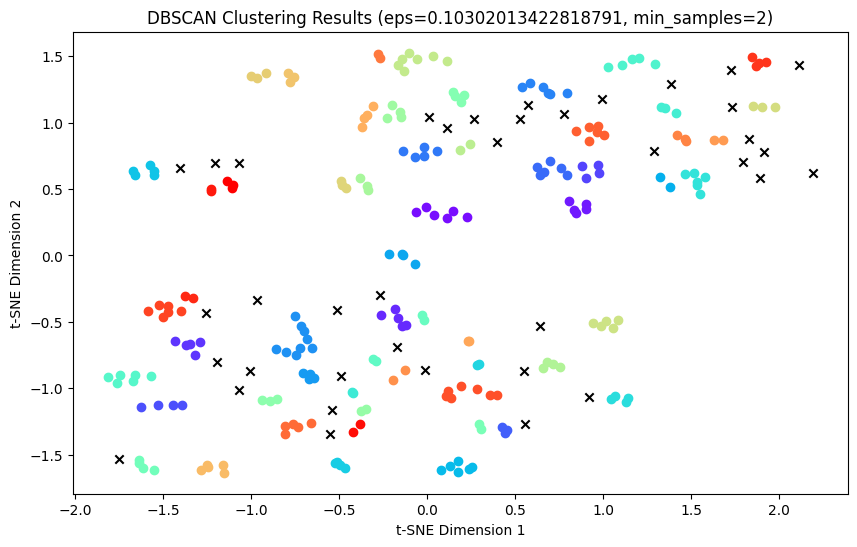

In [20]:
# Plotting the clusters on a two-dimensional plane
plt.figure(figsize=(10, 6))
for i, cluster_num in enumerate(np.unique(cluster_labels)):
    if cluster_num == -1:
        plt.scatter(scaled_features_df[scaled_features_df['pred_cluster'] == cluster_num][0], scaled_features_df[scaled_features_df['pred_cluster'] == cluster_num][1],
                    color='black', marker='x', label='Noise')
    else:
        plt.scatter(scaled_features_df[scaled_features_df['pred_cluster'] == cluster_num][0], scaled_features_df[scaled_features_df['pred_cluster'] == cluster_num][1],
                    color=cmap[i], label=f'Cluster {cluster_num}')

plt.title(f'DBSCAN Clustering Results (eps={selected_eps}, min_samples={selected_min_samples})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## Section F - Evaluation:
In this section, I will compare:
1. The performance of the K-Means model trained on the original data (section C), and K-Means trained on
the data after dimension reduction (Section D).

2. The performance of the K-Means model trained on the data after dimension reduction (section D), and
DBSCAN performance (Section E).

The main measures I chose to perform the comparison according to are: Inertia and Silhouette score.

In addition, I will define 2 more measures that will help me in the comparison. I will aim for the classification to produce clusters that are relatively balanced in size, so I will count how many clusters are too small in size (below a threshold value I will define 4), and how many clusters are too large in size (above a threshold value I will define 10). Since the image data is relatively balanced, I aim for each cluster to have between 4 and 10 images of a specific celebrity. The determination of these threshold values was determined after examining the data taking into account the total number of images and the number of selected clusters.

Therefore, I can claim that a model that produces a large amount of clusters with more than 10 images or less than 4 images, is a model that produces a large amount of abnormal clusters.

1. K-Means then T-SNE (section C) Vs. T-SNE then K-Means (section D)

Performing K-Means before T-SNE:

In [21]:
selected_k = 58  # The optimal K I selected
first_kmeans = KMeans(n_clusters=selected_k, n_init=10, random_state=42)  # Train a KMeans model with the selected K value
first_kmeans.fit(face_features)
cluster_labels = first_kmeans.labels_

inertia_before_tsne = first_kmeans.inertia_
silhouette_before_tsne = silhouette_score(face_features, cluster_labels)
unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

small_clusters_before_tsne = np.sum(label_counts < 4)  # Defining cluster as small if it contains less than 4 images
large_clusters_before_tsne = np.sum(label_counts > 10)  # Defining cluster as large if it contains more than 10 images

Performing T-SNE before K-Means:

In [22]:
tsne = TSNE(n_components=2, random_state=42)  # Reduce dimensions to 2 using t-SNE
tsne_features = tsne.fit_transform(face_features)  # A transformed feature array with reduced dimensions
tsne_df = pd.DataFrame(tsne_features)

second_kmeans = KMeans(n_clusters=selected_k, n_init=10, random_state=42)  # Train a KMeans model with the selected K value
second_kmeans.fit(tsne_df)
cluster_labels = second_kmeans.labels_

inertia_after_tsne = second_kmeans.inertia_
silhouette_after_tsne = silhouette_score(face_features, cluster_labels)
unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

small_clusters_after_tsne = np.sum(label_counts < 4)  # Defining cluster as small if it contains less than 4 images
large_clusters_after_tsne = np.sum(label_counts > 10)  # Defining cluster as large if it contains more than 10 images

Results Comparison:

In [23]:
c_d_comparison = pd.DataFrame({'Method': ['K-Means then T-SNE', 'T-SNE then K-Means'],
                               'Inertia Score': [inertia_before_tsne, inertia_after_tsne],
                               'Silhouette Score': [silhouette_before_tsne, silhouette_after_tsne],
                               'Num of Small Clusters': [small_clusters_before_tsne, small_clusters_after_tsne],
                               'Num of Large Clusters': [large_clusters_before_tsne, large_clusters_after_tsne]})
c_d_comparison

,Method,Inertia Score,Silhouette Score,Num of Small Clusters,Num of Large Clusters
0,K-Means then T-SNE,26.144820,0.211332,18,0
1,T-SNE then K-Means,140.376968,0.226509,18,0


I will set 'K-Means then T-SNE' as option 0, and 'T-SNE then K-Means' as option 1.
I will compare all the measures:

- Inertia Score: I would like to minimize the Inertia value, so option 0 is significantly better.

- Silhouette Score: I would like to maximize this value, and the difference seems to be negligible, although there is a slight advantage to option 0.

- Num of Small Clusters: I would like to minimize this metric, but there is equality between the two methods.

- Num of Large Clusters: I would like to minimize this metric, but there is equality between the two methods.

All in all, it is difficult to come to a significant decision which method is better. However, according to the results obtained, option 0 has a slight advantage in the Silhouette Score, and a significant advantage in the Inertia Score. Thus, I can claim it fits better in this case.

===================================================================================================================

2. T-SNE then K-Means (section D) Vs. T-SNE then DBSCAN (Section E)

In [24]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tsne_features)
scaled_features_df = pd.DataFrame(scaled_features)
selected_eps = 0.09637583892617449  # The optimal 'eps' we selected
selected_min_samples=2  # The optimal 'min_samples' we selected

dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_samples)  # Train a DBSCAN model with the selected 'eps' and 'min_samples' values
cluster_labels = pd.DataFrame(dbscan.fit_predict(scaled_features_df))
scaled_features_df['pred_cluster'] = cluster_labels
labels_without_noise = cluster_labels[cluster_labels != -1]

silhouette_dbscan = silhouette_score(scaled_features_df, cluster_labels.values.ravel())  # Convert the cluster_labels DataFrame into a 1D array
unique_labels, label_counts = np.unique(labels_without_noise, return_counts=True)

small_clusters_dbscan = np.sum(label_counts < 4)  # Defining cluster as small if it contains less than 4 images
large_clusters_dbscan = np.sum(label_counts > 10)  # Defining cluster as large if it contains more than 10 images

In [25]:
d_e_comparison = pd.DataFrame({'Method': ['T-SNE then K-Means', 'T-SNE then DBSCAN'],
                               'Silhouette Score': [silhouette_after_tsne, silhouette_dbscan],
                               'Num of Small Clusters': [small_clusters_after_tsne, small_clusters_dbscan],
                               'Num of Large Clusters': [large_clusters_after_tsne, large_clusters_dbscan]})
d_e_comparison

,Method,Silhouette Score,Num of Small Clusters,Num of Large Clusters
0,T-SNE then K-Means,0.226509,18,0
1,T-SNE then DBSCAN,0.784568,30,1


I will compare all the measures:

- Silhouette Score: I would like to maximize this value, so option 1 is significantly better.

- Num of Small Clusters: I would like to minimize this metric, so option 0 has an advantage.

- Num of Large Clusters: i would like to minimize this metric, so option 0 has an advantage.

All in all, it is difficult to come to a significant decision which method is better. Although option 1 has a Silhouette Score that is significantly better than option 0, it has a disadvantage in the amount of large and small (outlier) clusters, so it's hard to decide in this case.
